#Importar librerías

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, GridSearchCV, PredefinedSplit
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, classification_report, confusion_matrix, accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
import xgboost as xgb
from xgboost import XGBRegressor
import time
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
import xgboost as xgb

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
def histogramas(dataset):
  # Histogramas con la libreria matplotlib
  n = 0
  for m in dataset:
    plt.figure(n, figsize=(8,5))
    plt.grid()
    sns.histplot(dataset.iloc[:, n], kde = True, bins=20)
    plt.ylabel("Frecuencia",font= font_l)
    plt.xticks(font= font_l)
    plt.title(str(dataset.columns[n]), fontdict = font_e)
    n += 1

In [ ]:
def estadisticas(dataset):
  # Calculo de estadisticas utilizando la libreria numpy
  promedio = np.mean(dataset, axis = 0)
  mediana = np.median(dataset, axis = 0)
  valor_min = np.min(dataset, axis = 0)
  valor_max = np.max(dataset, axis = 0)
  desviacion_estandar = np.std(dataset, axis = 0)
  # Creacion de base de datos que contenga lo calculado anteriomente
  estadisticas = pd.DataFrame(
                list(zip(promedio, mediana, valor_min, valor_max,
                         desviacion_estandar)),
                index = list(dataset.columns),
                columns = ['promedio', 'mediana', 'valor minimo',
                           'valor maximo', 'desviacion estandar'])

  return estadisticas

#Se lee el Dataset

In [ ]:
file_path = '/content/drive/MyDrive/dataset.csv'
spotify_data = pd.read_csv(file_path, delimiter = ',')


In [ ]:
spotify_data.head(3)

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.461,...,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.166,...,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.359,...,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332,4,acoustic


#Se eliminan las columnas que no aportan al modelo de predicción

In [ ]:
spotify_data = spotify_data.dropna()

track_genre = spotify_data['track_genre']
popularity = spotify_data['popularity']
artists = spotify_data['artists']

spotify_data = spotify_data.drop(['Unnamed: 0','track_id','artists','album_name','track_name', 'time_signature','track_genre'], axis=1)

spotify_data['explicit'] = spotify_data['explicit'].apply(lambda explicit: 0 if explicit == False else 1)

spotify_data.head(3)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,73,230666,0,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917
1,55,149610,0,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489
2,57,210826,0,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332


In [ ]:
spotify_data.head(3)

,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,73,230666,0,0.676,0.461,1,-6.746,0,0.1430,0.0322,0.000001,0.358,0.715,87.917
1,55,149610,0,0.420,0.166,1,-17.235,1,0.0763,0.9240,0.000006,0.101,0.267,77.489
2,57,210826,0,0.438,0.359,0,-9.734,1,0.0557,0.2100,0.000000,0.117,0.120,76.332


#Se plotea la matriz de correlaciones

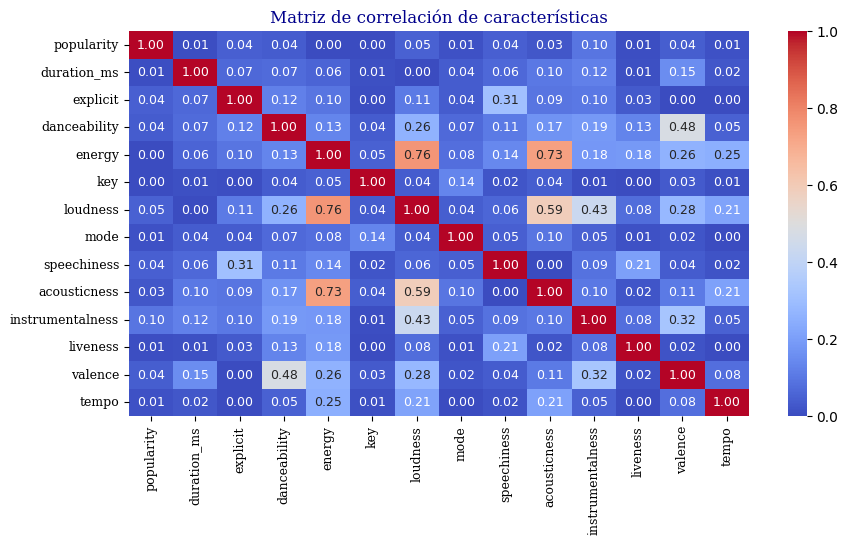

In [ ]:
font_e = {'family': 'serif','color': 'darkblue','weight': 'normal','size': 12,}
font_l = {'family': 'serif','size': 9,}

spotify_data_corr = spotify_data.copy()
matriz_corr = spotify_data_corr.corr().abs()

plt.figure(figsize=(10, 5))
sns.heatmap(matriz_corr, annot=True, fmt=".2f", cmap="coolwarm", annot_kws={"fontsize": 9}, vmin=0, vmax=1)
plt.title('Matriz de correlación de características', fontdict = font_e)
plt.xticks(rotation=90, font= font_l)
plt.yticks(rotation=0, font = font_l)
plt.show()

#Se muestran los elementos más correlacionados

In [ ]:
# ordenar la columna "popularity" de la matriz de correlación de manera descendente
corr_class = matriz_corr['popularity'].sort_values(ascending=False)

# imprimir las características más correlacionadas con popularity
print(corr_class)

popularity          1.000000
instrumentalness    0.095147
loudness            0.050420
speechiness         0.044930
explicit            0.044078
valence             0.040522
danceability        0.035444
acousticness        0.025458
mode                0.013948
tempo               0.013212
duration_ms         0.007129
liveness            0.005397
key                 0.003847
energy              0.001053
Name: popularity, dtype: float64


#Se muestran las estadisticas de los atributos

In [ ]:
estadisticas(spotify_data)

,promedio,mediana,valor minimo,valor maximo,desviacion estandar
popularity,33.238827,35.000000,0.000,100.000,22.304861
duration_ms,228031.153387,212906.000000,8586.000,5237295.000,107295.587114
explicit,0.085501,0.000000,0.000,1.000,0.279625
danceability,0.566801,0.580000,0.000,0.985,0.173542
energy,0.641383,0.685000,0.000,1.000,0.251529
key,5.309126,5.000000,0.000,11.000,3.559984
loudness,-8.258950,-7.004000,-49.531,4.532,5.029335
mode,0.637558,1.000000,0.000,1.000,0.480705
speechiness,0.084652,0.048900,0.000,0.965,0.105732
acousticness,0.314907,0.169000,0.000,0.996,0.332521


#Se crea una función que entregue los histogramas de todo el Dataframe

In [ ]:
histogramas(spotify_data)

In [ ]:
x=spotify_data.iloc[:,2].to_frame()
y=spotify_data.iloc[:,0]

In [ ]:
x

,explicit
0,0
1,0
2,0
3,0
4,0
...,...
113995,0
113996,0
113997,0
113998,0


In [ ]:
y

0         73
1         55
2         57
3         71
4         82
          ..
113995    21
113996    22
113997    22
113998    41
113999    22
Name: popularity, Length: 113999, dtype: int64

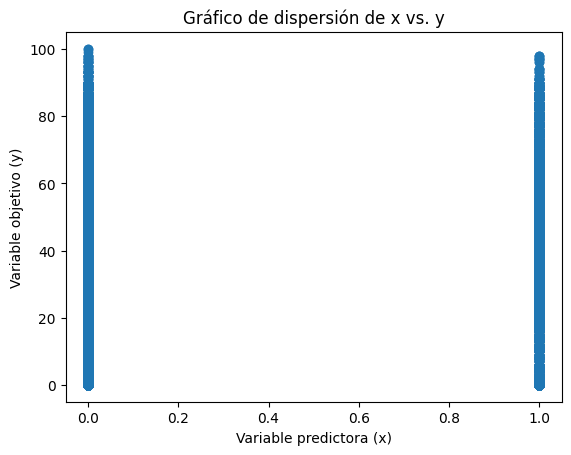

In [ ]:
plt.scatter(x,y)

# Agregar etiquetas y título al gráfico
plt.xlabel('Variable predictora (x)')
plt.ylabel('Variable objetivo (y)')
plt.title('Gráfico de dispersión de x vs. y')

# Mostrar el gráfico
plt.show()

#Se dividen los datos 60/20/20 para entrenar los modelos

In [ ]:
# Dividir los datos en características y etiquetas
X = spotify_data.iloc[:, 1:]
y = spotify_data.iloc[:, 0]

# Dividir los datos en conjuntos de entrenamiento (60%), validación (20%) y prueba (20%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5)

#Normalización de los datos

In [ ]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Regresion Lineal

                   Métrica Conjunto de Validación Conjunto de Prueba
0                      MSE              487.70836         481.606559
1                     RMSE               22.08412          21.945536
2                      MAE              18.438754          18.362396
3                       R²                0.02244           0.029996
4  Tiempo de Entrenamiento                      -           0.061075



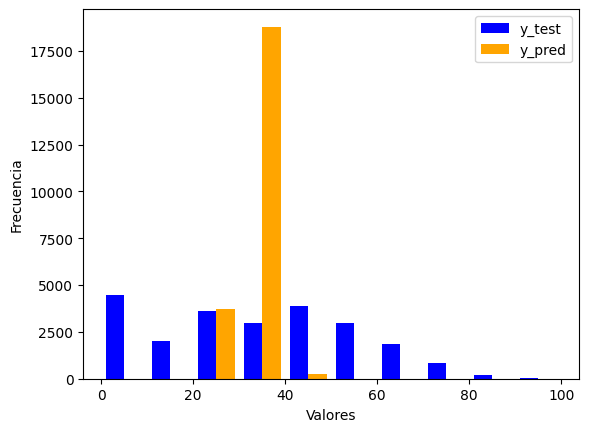

In [ ]:
# Crear el modelo de regresión lineal
regression_model = LinearRegression()

# Medir el tiempo de entrenamiento
start_time = time.time()
regression_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de validación
y_val_pred = regression_model.predict(X_val)

# Calcular métricas de desempeño en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = regression_model.predict(X_test)

# Calcular métricas de desempeño en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Crear un DataFrame con los resultados
results_df_1 = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'Tiempo de Entrenamiento'],
    'Conjunto de Validación': [mse_val, rmse_val, mae_val, r2_val, '-'],
    'Conjunto de Prueba': [mse_test, rmse_test, mae_test, r2_test, '-']
})

# Agregar el tiempo de entrenamiento a la tabla
results_df_1.at[4, 'Conjunto de Validación'] = '-'
results_df_1.at[4, 'Conjunto de Prueba'] = training_time

print(results_df_1)
print('')

plt.hist([y_test, y_val_pred], bins=10, color=['blue', 'orange'], label=['y_test', 'y_pred'])

# Añadir etiquetas y leyendas
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

# Gradient Boosting

                   Métrica Conjunto de Validación Conjunto de Prueba
0                      MSE             455.813773         449.378211
1                     RMSE              21.349796          21.198543
2                      MAE              17.588407          17.475827
3                       R²               0.086369           0.094907
4  Tiempo de Entrenamiento                      -          32.380261



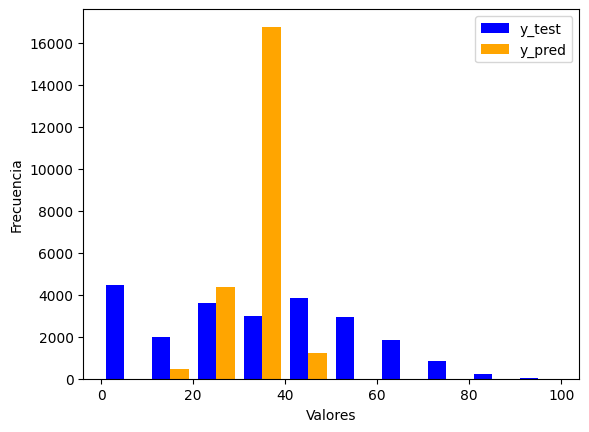

In [ ]:
# Crear el modelo de Regresión de Gradiente
gradient_boosting_model = GradientBoostingRegressor()

# Medir el tiempo de entrenamiento
start_time = time.time()
gradient_boosting_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de validación
y_val_pred = gradient_boosting_model.predict(X_val)

# Calcular métricas de desempeño en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = gradient_boosting_model.predict(X_test)

# Calcular métricas de desempeño en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Crear un DataFrame con los resultados
results_df_4 = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'Tiempo de Entrenamiento'],
    'Conjunto de Validación': [mse_val, rmse_val, mae_val, r2_val, '-'],
    'Conjunto de Prueba': [mse_test, rmse_test, mae_test, r2_test, '-']
})

# Agregar el tiempo de entrenamiento a la tabla
results_df_4.at[4, 'Conjunto de Validación'] = '-'
results_df_4.at[4, 'Conjunto de Prueba'] = training_time

print(results_df_4)
print('')

plt.hist([y_test, y_val_pred], bins=10, color=['blue', 'orange'], label=['y_test', 'y_pred'])

# Añadir etiquetas y leyendas
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

# XGBoost

                   Métrica Conjunto de Validación Conjunto de Prueba
0                      MSE             377.779478         372.563476
1                     RMSE               19.43655          19.301903
2                      MAE              15.610246          15.479629
3                       R²               0.242781            0.24962
4  Tiempo de Entrenamiento                      -          10.205228



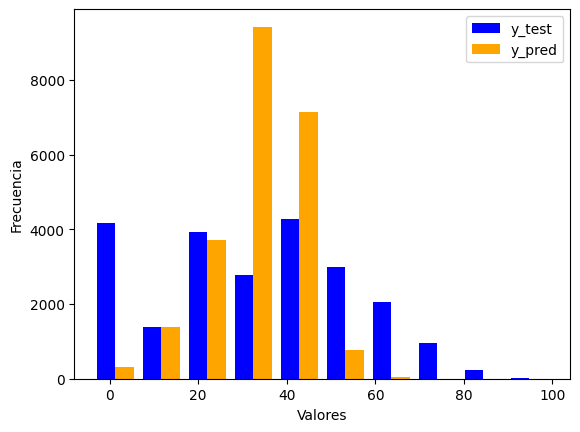

In [ ]:
# Crear el modelo de XGBoost para regresión
xgb_model = xgb.XGBRegressor()

# Medir el tiempo de entrenamiento
start_time = time.time()
xgb_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de validación
y_val_pred = xgb_model.predict(X_val)

# Calcular métricas de desempeño en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = xgb_model.predict(X_test)

# Calcular métricas de desempeño en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Crear un DataFrame con los resultados
results_df_5 = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'Tiempo de Entrenamiento'],
    'Conjunto de Validación': [mse_val, rmse_val, mae_val, r2_val, '-'],
    'Conjunto de Prueba': [mse_test, rmse_test, mae_test, r2_test, '-']
})

# Agregar el tiempo de entrenamiento a la tabla
results_df_5.at[4, 'Conjunto de Validación'] = '-'
results_df_5.at[4, 'Conjunto de Prueba'] = training_time

print(results_df_5)
print('')

plt.hist([y_test, y_val_pred], bins=10, color=['blue', 'orange'], label=['y_test', 'y_pred'])

# Añadir etiquetas y leyendas
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

# PCA

In [ ]:
# Aplicar PCA para reducir la dimensionalidad del conjunto de entrenamiento
pca = PCA(n_components=10)
X_train_pca = pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# SVR

                   Métrica Conjunto de Validación Conjunto de Prueba
0                      MSE             461.547298         449.986297
1                     RMSE              21.483652           21.21288
2                      MAE              17.235084          17.052147
3                       R²               0.074877           0.093682
4  Tiempo de Entrenamiento                      -         262.932688



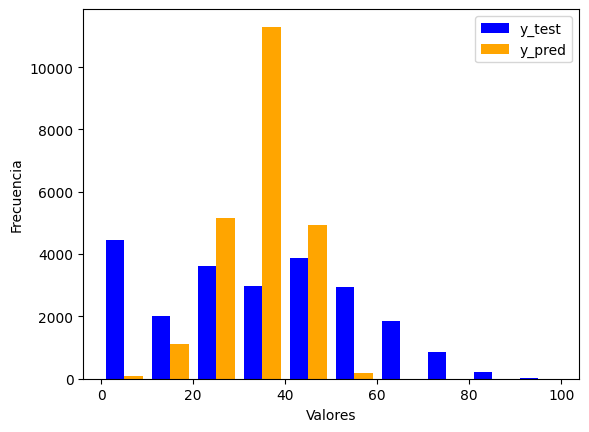

In [ ]:
# Crear el modelo de Máquinas de Soporte Vectorial con Regresión (SVR)
svr_model = SVR()

# Medir el tiempo de entrenamiento
start_time = time.time()
svr_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de validación
y_val_pred = svr_model.predict(X_val)

# Calcular métricas de desempeño en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = svr_model.predict(X_test)

# Calcular métricas de desempeño en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Crear un DataFrame con los resultados
results_df_7 = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'Tiempo de Entrenamiento'],
    'Conjunto de Validación': [mse_val, rmse_val, mae_val, r2_val, '-'],
    'Conjunto de Prueba': [mse_test, rmse_test, mae_test, r2_test, '-']
})

# Agregar el tiempo de entrenamiento a la tabla
results_df_7.at[4, 'Conjunto de Validación'] = '-'
results_df_7.at[4, 'Conjunto de Prueba'] = training_time

print(results_df_7)
print('')

plt.hist([y_test, y_val_pred], bins=10, color=['blue', 'orange'], label=['y_test', 'y_pred'])

# Añadir etiquetas y leyendas
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

# Random Forest

                   Métrica Conjunto de Validación Conjunto de Prueba
0                      MSE             252.905406         256.572424
1                     RMSE                 15.903          16.017878
2                      MAE              11.501782           11.54853
3                       R²               0.493078           0.483237
4  Tiempo de Entrenamiento                      -          94.808832



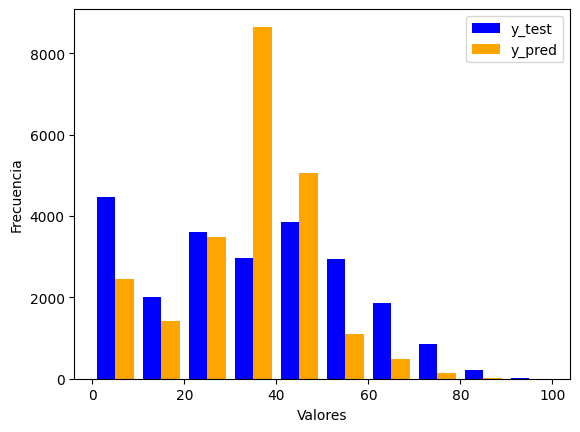

In [ ]:
# Crear el modelo de Bosque Aleatorio
random_forest_model = RandomForestRegressor()

# Medir el tiempo de entrenamiento
start_time = time.time()
random_forest_model.fit(X_train, y_train)
training_time = time.time() - start_time

# Realizar predicciones en el conjunto de validación
y_val_pred = random_forest_model.predict(X_val)

# Calcular métricas de desempeño en el conjunto de validación
mse_val = mean_squared_error(y_val, y_val_pred)
rmse_val = mean_squared_error(y_val, y_val_pred, squared=False)
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

# Realizar predicciones en el conjunto de prueba
y_test_pred = random_forest_model.predict(X_test)

# Calcular métricas de desempeño en el conjunto de prueba
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = mean_squared_error(y_test, y_test_pred, squared=False)
mae_test = mean_absolute_error(y_test, y_test_pred)
r2_test = r2_score(y_test, y_test_pred)

# Crear un DataFrame con los resultados
results_df_9 = pd.DataFrame({
    'Métrica': ['MSE', 'RMSE', 'MAE', 'R²', 'Tiempo de Entrenamiento'],
    'Conjunto de Validación': [mse_val, rmse_val, mae_val, r2_val, '-'],
    'Conjunto de Prueba': [mse_test, rmse_test, mae_test, r2_test, '-']
})

# Agregar el tiempo de entrenamiento a la tabla
results_df_9.at[4, 'Conjunto de Validación'] = '-'
results_df_9.at[4, 'Conjunto de Prueba'] = training_time

print(results_df_9)
print('')

plt.hist([y_test, y_val_pred], bins=10, color=['blue', 'orange'], label=['y_test', 'y_pred'])

# Añadir etiquetas y leyendas
plt.xlabel('Valores')
plt.ylabel('Frecuencia')
plt.legend()

# Mostrar el gráfico
plt.show()

# Resultados

In [ ]:
# Agregar una columna con el número del modelo en cada dataframe de resultados
results_df_1['Modelo'] = 'R L'
results_df_4['Modelo'] = 'G B'
results_df_5['Modelo'] = 'XGB'
results_df_7['Modelo'] = 'SVR'
results_df_9['Modelo'] = 'R F'

# Concatenar todos los dataframes en uno solo
all_results_df = pd.concat([results_df_1, results_df_4, results_df_5, results_df_7, results_df_9], ignore_index=True)

# Mostrar el dataframe con todos los resultados
print(all_results_df)

                    Métrica Conjunto de Validación Conjunto de Prueba Modelo
0                       MSE              487.70836         481.606559    R L
1                      RMSE               22.08412          21.945536    R L
2                       MAE              18.438754          18.362396    R L
3                        R²                0.02244           0.029996    R L
4   Tiempo de Entrenamiento                      -           0.061075    R L
5                       MSE             455.813773         449.378211    G B
6                      RMSE              21.349796          21.198543    G B
7                       MAE              17.588407          17.475827    G B
8                        R²               0.086369           0.094907    G B
9   Tiempo de Entrenamiento                      -          32.380261    G B
10                      MSE             377.779478         372.563476    XGB
11                     RMSE               19.43655          19.301903    XGB